In [1]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math
from pathlib import Path

from fastai.dataset import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.structured import *

import pdb

import pickle
from sklearn.model_selection import train_test_split

from IPython.display import FileLink
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"
rsna_path = Path(ddir)

detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [3]:
BBOX_CSV = '../tmp/rsna_bbox.csv'
TRN = 'train'
TEST = 'test2'

In [4]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)

In [5]:
md = ImageClassifierData.from_csv(rsna_path, TRN, BBOX_CSV, tfms=tfms, bs=64, test_name=TEST, continuous=True, suffix='.dcm')

In [ ]:
# n_sample

In [6]:
TRN_FILES = list((rsna_path/TRN).glob('*.dcm'))

In [7]:
RANDOM_TRN_FILES = np.random.shuffle(TRN_FILES)

In [8]:
n_sample = int(0.10 * len(TRN_FILES))

In [ ]:
(rsna_path/'sample').mkdir(exist_ok=True)
(rsna_path/'sample/train').mkdir(exist_ok=True)
(rsna_path/'sample/test').mkdir(exist_ok=True)

In [ ]:
! ls {rsna_path/'sample'}

In [ ]:
len(stage_1_train_labels_csv)

In [ ]:
df_sample = stage_1_train_labels_csv.sample(n=n_sample).reset_index(); len(df_sample)

In [ ]:
SAMPLE_TRN_LABELS = '../tmp/rsna_train_sample.feather'

In [ ]:
df_sample.to_feather(SAMPLE_TRN_LABELS)

In [ ]:
df_sample = pd.read_feather(SAMPLE_TRN_LABELS)

In [ ]:
def bbox_corners(row):
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height'] 
    if math.isnan(x):
        return "0 0 0 0"
    
    x2 = x + width
    y2 = y + height
    return f"{x} {y} {x2} {y2}" 

In [ ]:
# of rows where Target = 1
n_rows_target_1 = len(df_sample[df_sample['Target'] != 0])
n_rows_target_1 / n_sample

In [ ]:
df_sample['bbox_corners'] = df_sample.apply(bbox_corners, axis=1)

In [ ]:
df_sample_bbox_corners = df_sample[['patientId', 'bbox_corners']]

In [9]:
BBOX_CSV_CORNERS = '../tmp/df_sample_bbox_corners.csv'

In [ ]:
df_sample_bbox_corners.to_csv(BBOX_CSV_CORNERS, index=False)

In [10]:
df_sample_bbox_corners = pd.read_csv(BBOX_CSV_CORNERS)

In [ ]:
df_sample_bbox_corners[:10]

In [12]:
cv_idxs = get_cv_idxs(len(df_sample_bbox_corners), val_pct=0.2)

In [ ]:
len(cv_idxs)

In [13]:
md = ImageClassifierData.from_csv(rsna_path, TRN, BBOX_CSV_CORNERS, 
                                  bs=64, tfms=tfms, val_idxs=cv_idxs, continuous=True, suffix='.dcm')

In [ ]:
ds = pydicom.dcmread(str(rsna_path/md.trn_ds.fnames[0]))
size = ds.pixel_array.shape
X_scaling = size[0] / 224. 
Y_scaling = size[1] / 224.

In [14]:
x, y = next(iter(md.trn_dl))

In [ ]:
image_data = to_np(md.trn_ds.denorm(x))[1]
bbox = to_np(y[1]).tolist()
x_img, y_img, x2_img, y2_img = bbox

In [ ]:
fi, ax = plt.subplots()
ax.imshow(image_data)
rect = Rectangle((x_img,y_img), (x2_img-x_img), (y2_img-y_img), linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)

In [15]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 1.5e-3

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [65]:
learn.save('../tmp/bbox.pth')

In [16]:
learn.load('../tmp/bbox.pth')

In [66]:
x, y = next(iter(md.trn_dl))

In [67]:
y[:10]

tensor([[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [ 33.,  40.,  79.,  75.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]], device='cuda:0')

In [68]:
preds = to_np(predict_batch(learn.model, x)); preds[:10]

array([[ 23.2045 ,  22.46175,  35.05435,  30.80185],
       [  3.30284, -18.79561,  -9.79368,   2.39806],
       [ -5.40884,  12.23434,   2.88613,   0.88604],
       [  1.9606 ,   3.91816,   9.73489,  19.83698],
       [-10.38313,   4.87275,   4.96105,  -5.57345],
       [ 31.64552,  16.5351 ,  48.68837,  39.69324],
       [ -9.30796,  -7.58573,  10.35597,  24.31953],
       [-17.68835,   5.76331,  -7.12819,   9.66144],
       [-16.04656,  -9.73336, -10.7971 , -10.32385],
       [ 23.73164,  23.64269,  28.6518 ,  30.34227]], dtype=float32)

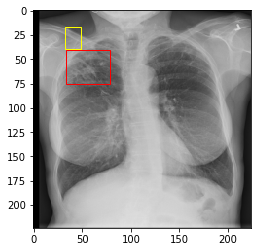

In [69]:
index = 5
image_data = to_np(md.trn_ds.denorm(x))[index]
bbox = to_np(y[index]).tolist()
x_img, y_img, x2_img, y2_img = bbox

fi, ax = plt.subplots()
ax.imshow(image_data)
rect = Rectangle((x_img,y_img), (x2_img-x_img), (y2_img-y_img), linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)

bbox = to_np(learn.model(VV(x)))[index].tolist()
x_img, y_img, x2_img, y2_img = bbox
rect2 = Rectangle((x_img,y_img), (x2_img-x_img), (y2_img-y_img), linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect2)

In [70]:
test_preds = learn.predict(is_test=True)

In [21]:
preds, y = learn.TTA()

In [26]:
md2 = ImageClassifierData.from_csv(rsna_path, TRN, BBOX_CSV_CORNERS, 
                                  bs=64, tfms=tfms, val_idxs=cv_idxs, continuous=True, suffix='.dcm', test_name='test2')

In [27]:
learn.set_data(md2)

In [ ]:
dir(md.trn_y)

In [ ]:
idx = 2
SCALING_FACTOR = (1024/224.)
md.trn_y

In [ ]:
x_, y_ = next(iter(md.trn_dl))

In [28]:
test_preds = learn.predict(is_test=True)

In [46]:
md2.trn_ds.y[3]

array([ 614.,  176.,  777.,  356.], dtype=float32)

In [49]:
md2.trn_ds.sz

224

In [50]:
(1024 / 224)

4.571428571428571

In [71]:
test_preds_resized = test_preds*(1024 / 224)

In [53]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 26/33 [00:21<00:05,  1.22it/s, loss=103] 

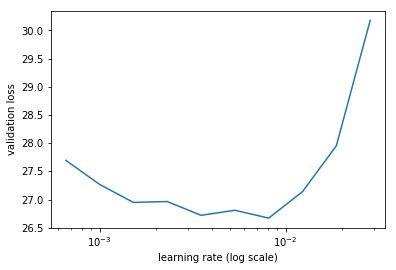

In [55]:
learn.sched.plot()

In [56]:
lr = 1.5e-2

In [57]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

 21%|██        | 7/33 [00:08<00:30,  1.17s/it, loss=42]  

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/edwin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/edwin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      45.04282   39.793583 
    1      35.56278   33.33376                            
    2      36.721676  37.3174                             
    3      32.213792  33.748808                           



[33.748808438782568]

In [58]:
lrs = np.array([lr/1000,lr/100,lr])

In [59]:
learn.freeze_to(-2)

In [60]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      44.840538  40.104607 



[40.104606814319396]

In [62]:
learn.unfreeze()

In [64]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      43.333283  38.394896 
    1      32.77035   36.591612                           



[36.591611539643644]

In [76]:
test_preds_clipped = np.clip(np.array(test_preds_resized), 0, 1024).tolist()

In [99]:
test_preds_clipped[0][0:4]

[412.5340270996094, 303.5760192871094, 556.9641723632812, 727.836669921875]

In [114]:
def convert_bb_width_height(row):
    x1 = float(row[0])
    y1 = float(row[1])
    x2 = float(row[2])
    y2 = float(row[3])
    
    
    width = x2 - x1
    height = y2 - y1
    
    return f"1.0 {x1} {y1} {width} {height}"

In [117]:
results = list(zip(md2.test_ds.fnames, test_preds_clipped))
df_test = pd.DataFrame(results, columns=['patientId', 'PredictionString'])
df_test['PredictionString'] = df_test['PredictionString'].map( convert_bb_width_height )
df_test['patientId'] = df_test['patientId'].map( lambda x: x.split('/')[1].split('.dcm')[0])

submit_file = '../tmp/submission_0930.csv'
df_test.to_csv(submit_file, index=False)
FileLink(submit_file)

/home/edwin/Developer/kaggle-comps/tmp/submission_0930.csv

In [116]:
df_test[:10]

,patientId,PredictionString
0,21afc084-1c98-42f5-b767-edb5cb8f2884,1.0 412.5340270996094 303.5760192871094 144.43...
1,0ed09fd0-a4f5-4440-9fe7-6272d7987f33,1.0 30.875993728637695 14.78087043762207 49.48...
2,0e266ced-46fe-4868-8a5a-ef1be71d8f9a,1.0 0.0 17.809661865234375 0.0 -17.80966186523...
3,005f5517-ab76-4b0d-8a26-f808d97171c4,1.0 0.0 0.0 0.0 0.0
4,2f50a1ca-ebd8-4688-863b-fe85ce09c526,1.0 123.64108276367188 150.22459411621094 106....
5,2db71952-47f3-455b-aed2-675ec9113cf3,1.0 160.21963500976562 15.165703773498535 -10....
6,2d370cb1-791e-407e-9408-9156664de6b6,1.0 104.54363250732422 116.96226501464844 74.6...
7,28775c77-80e8-4f8c-be85-7a44162b5c28,1.0 34.409358978271484 0.0 73.32372665405273 5...
8,2d9bfa9e-b4c9-4ab2-98d6-f821d61435e2,1.0 44.01919174194336 0.0 122.15298843383789 1...
9,02e68787-7eae-4b26-9d01-c5782b825fdc,1.0 0.0 111.58338928222656 22.85423469543457 -...


In [113]:
df_test[:10]

,patientId,PredictionString
0,21afc084-1c98-42f5-b767-edb5cb8f2884,1.0 412.5340270996094 303.5760192871094 556.96...
1,0ed09fd0-a4f5-4440-9fe7-6272d7987f33,1.0 30.875993728637695 14.78087043762207 80.35...
2,0e266ced-46fe-4868-8a5a-ef1be71d8f9a,1.0 0.0 17.809661865234375 0.0 0.0
3,005f5517-ab76-4b0d-8a26-f808d97171c4,1.0 0.0 0.0 0.0 0.0
4,2f50a1ca-ebd8-4688-863b-fe85ce09c526,1.0 123.64108276367188 150.22459411621094 230....
5,2db71952-47f3-455b-aed2-675ec9113cf3,1.0 160.21963500976562 15.165703773498535 149....
6,2d370cb1-791e-407e-9408-9156664de6b6,1.0 104.54363250732422 116.96226501464844 179....
7,28775c77-80e8-4f8c-be85-7a44162b5c28,1.0 34.409358978271484 0.0 107.73308563232422 ...
8,2d9bfa9e-b4c9-4ab2-98d6-f821d61435e2,1.0 44.01919174194336 0.0 166.17218017578125 1...
9,02e68787-7eae-4b26-9d01-c5782b825fdc,1.0 0.0 111.58338928222656 22.85423469543457 4...


In [86]:
stage_1_sample_submission_csv[:10]

,patientId,PredictionString
0,000924cf-0f8d-42bd-9158-1af53881a557,0.5 0 0 100 100
1,000db696-cf54-4385-b10b-6b16fbb3f985,0.5 0 0 100 100
2,000fe35a-2649-43d4-b027-e67796d412e0,0.5 0 0 100 100
3,001031d9-f904-4a23-b3e5-2c088acd19c6,0.5 0 0 100 100
4,0010f549-b242-4e94-87a8-57d79de215fc,0.5 0 0 100 100
5,001916b8-3d30-4935-a5d1-8eaddb1646cd,0.5 0 0 100 100
6,0022073f-cec8-42ec-ab5f-bc2314649235,0.5 0 0 100 100
7,0022995a-45eb-4cfa-9a59-cd15f5196c64,0.5 0 0 100 100
8,0025d2de-bd78-4d36-9f72-e15a5e22ca82,0.5 0 0 100 100
9,00293de0-a530-41dc-9621-0b3def01d06d,0.5 0 0 100 100


In [104]:
df_test[:10]

,patientId,PredictionString
0,test2/21afc084-1c98-42f5-b767-edb5cb8f2884.dcm,"[412.5340270996094, 303.5760192871094, 556.964..."
1,test2/0ed09fd0-a4f5-4440-9fe7-6272d7987f33.dcm,"[30.875993728637695, 14.78087043762207, 80.356..."
2,test2/0e266ced-46fe-4868-8a5a-ef1be71d8f9a.dcm,"[0.0, 17.809661865234375, 0.0, 0.0]"
3,test2/005f5517-ab76-4b0d-8a26-f808d97171c4.dcm,"[0.0, 0.0, 0.0, 0.0]"
4,test2/2f50a1ca-ebd8-4688-863b-fe85ce09c526.dcm,"[123.64108276367188, 150.22459411621094, 230.2..."
5,test2/2db71952-47f3-455b-aed2-675ec9113cf3.dcm,"[160.21963500976562, 15.165703773498535, 149.7..."
6,test2/2d370cb1-791e-407e-9408-9156664de6b6.dcm,"[104.54363250732422, 116.96226501464844, 179.2..."
7,test2/28775c77-80e8-4f8c-be85-7a44162b5c28.dcm,"[34.409358978271484, 0.0, 107.73308563232422, ..."
8,test2/2d9bfa9e-b4c9-4ab2-98d6-f821d61435e2.dcm,"[44.01919174194336, 0.0, 166.17218017578125, 1..."
9,test2/02e68787-7eae-4b26-9d01-c5782b825fdc.dcm,"[0.0, 111.58338928222656, 22.85423469543457, 4..."


In [119]:
# area of overlap / area of 
def calculate_iou():
    return

In [120]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


In [121]:
max(1,2)

2